# Cognition & Computation - Lab 1

In [ ]:
# 🔧 Setup for Google Colab
import os
import sys

# Check if running on Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("🔧 Running on Google Colab - setting up environment...\n")
    
    # Clone repository if not already done
    if not os.path.exists('groundeep-unimodal-training'):
        print("📥 Cloning repository...")
        !git clone https://github.com/francesco-cal98/dbn-training.git groundeep-unimodal-training
    
    # Change to repo directory
    os.chdir('groundeep-unimodal-training')
    print(f"📂 Working directory: {os.getcwd()}")
    
    # Install minimal dependencies
    print("\n📦 Installing dependencies...")
    !pip install -q torch torchvision numpy matplotlib scikit-learn tqdm
    
    print("\n✅ Setup complete! Ready to run the notebook.\n")
else:
    print("💻 Running locally")

First step: download two simple scripts implementing a Deep Belief Network in PyTorch and import a few Python libraries.

In [ ]:
def get_dbn_library():  """  Load DBN library from local implementation.    This uses the wrapper classes (DBN.py, RBM.py) which internally use  the implementation from src/classes/gdbn_model.py.    No download needed - files are already in the repository!  """  import os    # Check if wrapper files exist  if not os.path.exists('DBN.py'):    raise FileNotFoundError(      "DBN.py not found. Make sure you're running from the repository root."    )  if not os.path.exists('RBM.py'):    raise FileNotFoundError(      "RBM.py not found. Make sure you're running from the repository root."    )    print("✅ Using local DBN implementation")  print("   - Wrapper classes: DBN.py, RBM.py")  print("   - Core implementation: src/classes/gdbn_model.py")

In [ ]:
%%capture
get_dbn_library()

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv

from DBN import DBN

We can choose dynamically the kind of hardware device used for computations (CPU or GPU).

In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

Then, let's download the MNIST dataset. We download both the train and test datasets (we will use the test set later on). We divide each pixel by the maximum value (255 in RGB notation) to get input values encoded between 0 and 1.
If using CUDA, we also need to transfer the data to the GPU.

In [ ]:
%%capture
mnist_tr = tv.datasets.MNIST(root="../mnist", train=True, download=True)
mnist_te = tv.datasets.MNIST(root="../mnist", train=False, download=True)

In [ ]:
mnist_tr.data = mnist_tr.data / 255
mnist_te.data = mnist_te.data / 255

In [ ]:
mnist_tr.data = mnist_tr.data.to(device)
mnist_te.data = mnist_te.data.to(device)
mnist_tr.targets = mnist_tr.targets.to(device)
mnist_te.targets = mnist_te.targets.to(device)

Let's visualize one training image:

In [ ]:
idx = 0
img = mnist_tr.data[idx].cpu()  # NB: to plot the data, we need to move it back from the GPU memory!
print("The image shows the digit: {}".format(mnist_tr.targets[idx]) )
plt.imshow(img , cmap = 'gray')
plt.show()

## Training a Deep Belief Network
Quick recall from the course theory:
- DBNs are hierarchical generative models made by a stack of Restricted Boltzmann Machines, which are a family of *undirected* graphical models;
- learning is *unsupervised*, since the goal is to learn the probability distribution that could have generated the training data (maximum-likelihood);
- DBNs can process the input data through a *forward* (bottom-up) pass to compute hidden representations of the sensory input ("inference" over latent variables);
- DBNs can also generate plausible sensory input through a *backward* (top-down) pass, which can be used to produce class prototypes;
- DBNs are trained using an algorithm called *contrastive divergence*, whose goal is to reduce the difference between the learned probability distribution and the true (empirical) one.

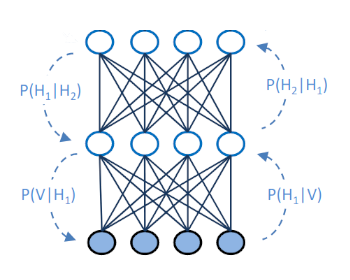

In [ ]:
dbn_mnist = DBN(visible_units=28*28,          # dimensionality of the sensory data
                hidden_units=[400, 500, 800], # size of hidden layers
                k=1,                          # reconstruction steps in Contrastive Divergence
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

Let's train the model:

In [ ]:
num_epochs = 50
batch_size = 125

dbn_mnist.train_static(
    mnist_tr.data,
    mnist_tr.targets,
    num_epochs,
    batch_size
)

## Visualizing receptive fields

After training, we can visualize the "receptive fields" of each hidden neuron by plotting the corresponding learned weights. This allows to analyze which parts and which features of an image trigger the unit associated with a specific weight vector.

It might also be useful to apply a threshold on the learned weights, in order to make the plots less noisy. Finally, the values in different weigths could have different ranges, so we will use a `MinMaxScaler` from Scikit-Learn to make a meaningful comparison among the visualizations of different receptive fields.

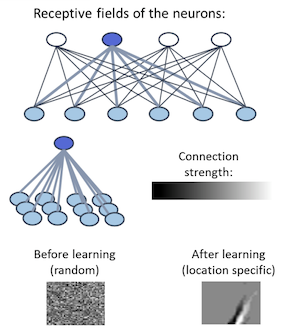

In [ ]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

In [ ]:
w1 = get_weights(dbn_mnist, layer=0)
w1 = apply_threshold(w1, 0.1)
w1 = apply_min_max_scaler(w1)

plot_layer_receptive_fields(w1.T)

The weights in the second and third hidden layers have don't have the same dimensionality as MNIST digits, therefore, we will need to project each of the vectors in a space of dimensionality `784` (`28`x`28`) in order to visualize them as images. The projection can be done in many ways, here for simplicity we consider a [linear projection](https://numpy.org/doc/stable/reference/generated/numpy.matmul.html).

In [ ]:
w1 = get_weights(dbn_mnist, layer=0)
w2 = get_weights(dbn_mnist, layer=1)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)

w_product = (w1 @ w2)  # here we do the projection
w_product = apply_threshold(w_product, 0.1)
w_product = apply_min_max_scaler(w_product)

plot_layer_receptive_fields(w_product.T)

In [ ]:
w1 = get_weights(dbn_mnist, layer=0)
w2 = get_weights(dbn_mnist, layer=1)
w3 = get_weights(dbn_mnist, layer=2)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)
w3 = apply_threshold(w3, 0.1)

w_product_12 = (w1 @ w2)  # here we do the projection
w_product_23 = (w_product_12 @ w3)  # here we do the projection
w_product_23 = apply_threshold(w_product_23, 0.1)
w_product_23 = apply_min_max_scaler(w_product_23)

plot_layer_receptive_fields(w_product_23.T)

## Clustering internal representations

We can also examine the properties of the learned *distributed* representations. For example, we can compute the centroid of the representations learned for each class, and see how close they are to each other using a standard hierarchical clustering algorithm.

This implementation of the `DBN` contains internally several `RBM` objects. Therefore, we will need to compute the hidden representation using the weights of each `RBM`.

In [ ]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_mnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

The representations computed for the second hidden layer are derived using the ones of the first hidden layer, and so on until we get to the deepest layer:

In [ ]:
hidden_repr_1 = get_kth_layer_repr(mnist_tr.data, 0, device)
hidden_repr_2 = get_kth_layer_repr(hidden_repr_1, 1, device)
hidden_repr_3 = get_kth_layer_repr(hidden_repr_2, 2, device)
print(hidden_repr_1.shape)
print(hidden_repr_2.shape)
print(hidden_repr_3.shape)

Finally, we compute the centroid (mean) of the representations of each class and we build a matrix containing all the centroids to comply with the input required by the clustering algorithm.

In [ ]:
def get_mask(label):  # we use this function to filter by class
  labels = mnist_tr.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_repr):
  hidden_repr_np = hidden_repr.cpu().numpy()
  return {
    label: hidden_repr_np[get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }

def get_hidden_reprs_matrix(hidden_repr):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_repr)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])

In [ ]:
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_3)

Now we can run the clustering algorithm and visualize it output in a dendrogram plot.

In [ ]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

In [ ]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

## Linear read-out

Another technique to analyze distributed representaitons is to decode them using a linear readout (as for the clustering, this can be done at each layer of the DBN). We will thus use the hidden representations to classify the MNIST images with a simple linear classifier, as a way to assess how much information is contained in each hidden representatation.
Let's first define the class for the linear classifier:

In [ ]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)

  def forward(self, x):
    return self.linear(x)

Then, we can instantiate a linear classifier for each hidden layer of the DBN:

In [ ]:
layer_size = dbn_mnist.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_mnist.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_mnist.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

Then, we train the linear classifiers on the hidden representations from each layer using the actual labels of the MNIST dataset as targets:

In [ ]:
def train_linear(linear, hidden_reprs):
  optimizer = torch.optim.SGD(linear.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()
  epochs = 1000

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = linear(hidden_reprs).squeeze()
    targets = mnist_tr.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [ ]:
train_linear(linear1, hidden_repr_1)

In [ ]:
train_linear(linear2, hidden_repr_2)

In [ ]:
train_linear(linear3, hidden_repr_3)

Let's now evaluate the trained linear readouts using the hidden representations computed on the *test* set:

In [ ]:
hidden_repr_1_test = get_kth_layer_repr(mnist_te.data, 0, device)
hidden_repr_2_test = get_kth_layer_repr(hidden_repr_1_test, 1, device)
hidden_repr_3_test = get_kth_layer_repr(hidden_repr_2_test, 2, device)

In [ ]:
# compute the classifier predictions:
predictions_test1 = linear1(hidden_repr_1_test)
predictions_test2 = linear2(hidden_repr_2_test)
predictions_test3 = linear3(hidden_repr_3_test)

Finally, let's compute the accuracy scores:

In [ ]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets).sum() / len(targets)
  return accuracy.item()

In [ ]:
compute_accuracy(predictions_test1, mnist_te.targets)

In [ ]:
compute_accuracy(predictions_test2, mnist_te.targets)

In [ ]:
compute_accuracy(predictions_test3, mnist_te.targets)

## Reference papers
- [G. Hinton - A Practical Guide to Training Restricted Boltzmann Machines](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf)
- [G. Hinton, R. Salakhutdinov - Reducing the Dimensionality of Data with Neural Networks](https://www.science.org/doi/10.1126/science.1127647)
- [Testolin et al. - Deep unsupervised learning on a desktop PC: a primer for cognitive scientists](https://www.frontiersin.org/articles/10.3389/fpsyg.2013.00251/full)


## Contacts

- 📧 flavio.petruzzellis@phd.unipd.it
- 💬 [Moodle forum](https://stem.elearning.unipd.it/mod/forum/view.php?id=600538)